In [48]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Set the random seed
np.random.seed(2)

# Set the default plotting style
sns.set(style='white', context='notebook', palette='deep')

In [49]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [ ]:
# Separate labels and features
Y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)

# Delete the original train dataframe to free up memory
del train

# Plot the count of each label
sns.countplot(Y_train)
plt.title("Distribution of Digit Labels")
plt.show()

We have similar counts for the 10 digits.

In [51]:
# Check for missing values
print("Missing values in training set:", X_train.isnull().any().sum())
print("Missing values in test set:", test.isnull().any().sum())

count       784
unique        1
top       False
freq        784
dtype: object

In [53]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [54]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [55]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [56]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)


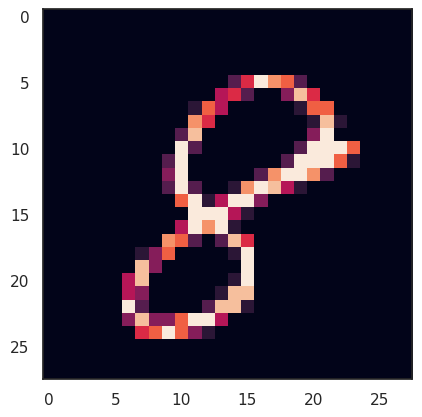

In [58]:
g = plt.imshow(X_train[0][:,:,0])

In [59]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [61]:
# Compile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [62]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [63]:
epochs = 30
batch_size = 86

In [64]:
# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

In [ ]:
# Fit the model using data augmentation
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
439/439 - 111s - loss: 0.4112 - accuracy: 0.8674 - val_loss: 0.0596 - val_accuracy: 0.9802 - lr: 0.0010 - 111s/epoch - 253ms/step
Epoch 2/30
439/439 - 110s - loss: 0.1281 - accuracy: 0.9616 - val_loss: 0.0458 - val_accuracy: 0.9855 - lr: 0.0010 - 110s/epoch - 250ms/step
Epoch 3/30
439/439 - 111s - loss: 0.0914 - accuracy: 0.9741 - val_loss: 0.0395 - val_accuracy: 0.9881 - lr: 0.0010 - 111s/epoch - 253ms/step
Epoch 4/30
439/439 - 111s - loss: 0.0762 - accuracy: 0.9771 - val_loss: 0.0268 - val_accuracy: 0.9910 - lr: 0.0010 - 111s/epoch - 252ms/step
Epoch 5/30
439/439 - 112s - loss: 0.0708 - accuracy: 0.9789 - val_loss: 0.0252 - val_accuracy: 0.9926 - lr: 0.0010 - 112s/epoch - 254ms/step
Epoch 6/30
439/439 - 111s - loss: 0.0651 - accuracy: 0.9808 - val_loss: 0.0260 - val_accuracy: 0.9910 - lr: 0.0010 - 111s/epoch - 253ms/step
Epoch 7/30
439/439 - 111s - loss: 0.0628 - accuracy: 0.9815 - val_loss: 0.0260 - val_accuracy: 0.9919 - lr: 0.0010 - 111s/epoch - 254ms/step
Epoch 8/30
43

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].set_title("Loss")
ax[0].legend(loc='best')
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_title("Accuracy")
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# Compute and plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the labels for validation set
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=range(10), normalize=True, title='Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display some error results
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    plt.figure(figsize=(10, 10))
    for i, error in enumerate(errors_index[:6]):
        plt.subplot(2, 3, i + 1)
        plt.imshow((img_errors[error]).reshape((28, 28)))
        plt.title("Predicted label: {}\nTrue label: {}".format(pred_errors[error], obs_errors[error]))
    plt.tight_layout()
    plt.show()

Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_delta_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
# Predict labels for the test set
results = model.predict(test)
results = np.argmax(results, axis=1)


In [ ]:
# Create a submission dataframe
submission = pd.DataFrame({'ImageId': range(1, len(results) + 1), 'Label': results})

# Save the submission file
submission.to_csv("cnn_mnist_datagen.csv", index=False)